<a href="https://colab.research.google.com/github/csharpshooter/EIP/blob/master/A5/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/EIP/Assignment5Dataset/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [1]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# print('Using real-time data augmentation.')  
# This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=90,
        # randomly shift images horizontally
        #width_shift_range=0.1,
        # randomly shift images vertically
        #height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=True,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level),
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        #validation_split=0.15
        )

In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),  
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        # if self.augmentation is not None:
        #     image = self.augmentation.flow(image,batch_size=self.batch_size,shuffle=False).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }

        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [8]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
12310,resized/12312.jpg,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
11601,resized/11603.jpg,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0
5179,resized/5180.jpg,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0
4936,resized/4937.jpg,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0
1834,resized/1835.jpg,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, shuffle=False, augmentation=datagen)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [10]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [11]:
backbone = VGG16(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(neck)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_tower_emotion(in_layer):
    neck = Dropout(0.4)(in_layer)
    neck = Dense(256, activation="relu")(neck)
    neck = Dropout(0.4)(neck)
    neck = Dense(256, activation="relu")(neck)
    return neck

def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower_emotion(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 45:
        lr *= 0.5e-3
    elif epoch > 35:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

    # lr = 0.5
    # if epoch > 45:
    #     lr *= 0.1
    # elif epoch > 40:
    #     lr *= 0.2
    # elif epoch > 30:
    #     lr *= 0.3
    # elif epoch > 20:
    #     lr *= 0.4
    # print('Learning rate: ', lr)
    # return lr

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [21]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [22]:
import os
import datetime
# Prepare model model saving directory.
# save_dir = os.path.join(os.getcwd(), 'saved_models')
t = datetime.datetime.today()
print(str(datetime.datetime.today()))
save_dir = "/content/gdrive/My Drive/EIP/Assignment5Dataset/saved_models"
model_name = 'A5_'+str(t)+'_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
filepath

2019-12-27 04:30:51.515671


'/content/gdrive/My Drive/EIP/Assignment5Dataset/saved_models/A5_2019-12-27 04:30:51.515601_model.{epoch:03d}.h5'

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, mode='min')

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

# callbacks = [checkpoint, lr_reducer, lr_scheduler]
callbacks = [checkpoint,es,lr_scheduler]

In [24]:
model_output = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
Learning rate:  0.001

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
360/360 [==============================] - 110s 306ms/step - loss: 5.4230 - gender_output_loss: 0.1830 - image_quality_output_loss: 0.8658 - age_output_loss: 1.2197 - weight_output_loss: 0.8223 - bag_output_loss: 0.6497 - footwear_output_loss: 0.5943 - pose_output_loss: 0.2607 - emotion_output_loss: 0.8274 - gender_output_acc: 0.9283 - image_quality_output_acc: 0.5911 - age_output_acc: 0.4603 - weight_output_acc: 0.6687 - bag_output_acc: 0.7345 - footwear_output_acc: 0.7409 - pose_output_acc: 0.9035 - emotion_output_acc: 0.7106 - val_loss: 7.1220 - val_gender_output_loss: 0.4966 - val_image_quality_output_loss: 0.9456 - val_age_output_loss: 1.4093 - val_weight_output_loss: 0.9537 - val_bag_output_loss: 0.8778 - val_footwear_output_loss: 0.8618 - val_pose_output_loss: 0.6694 - val_emotion_output_loss: 0.9077 - val_gender_output_acc: 0.8090 - val_image_quality_output_acc: 0.5585 - val_age

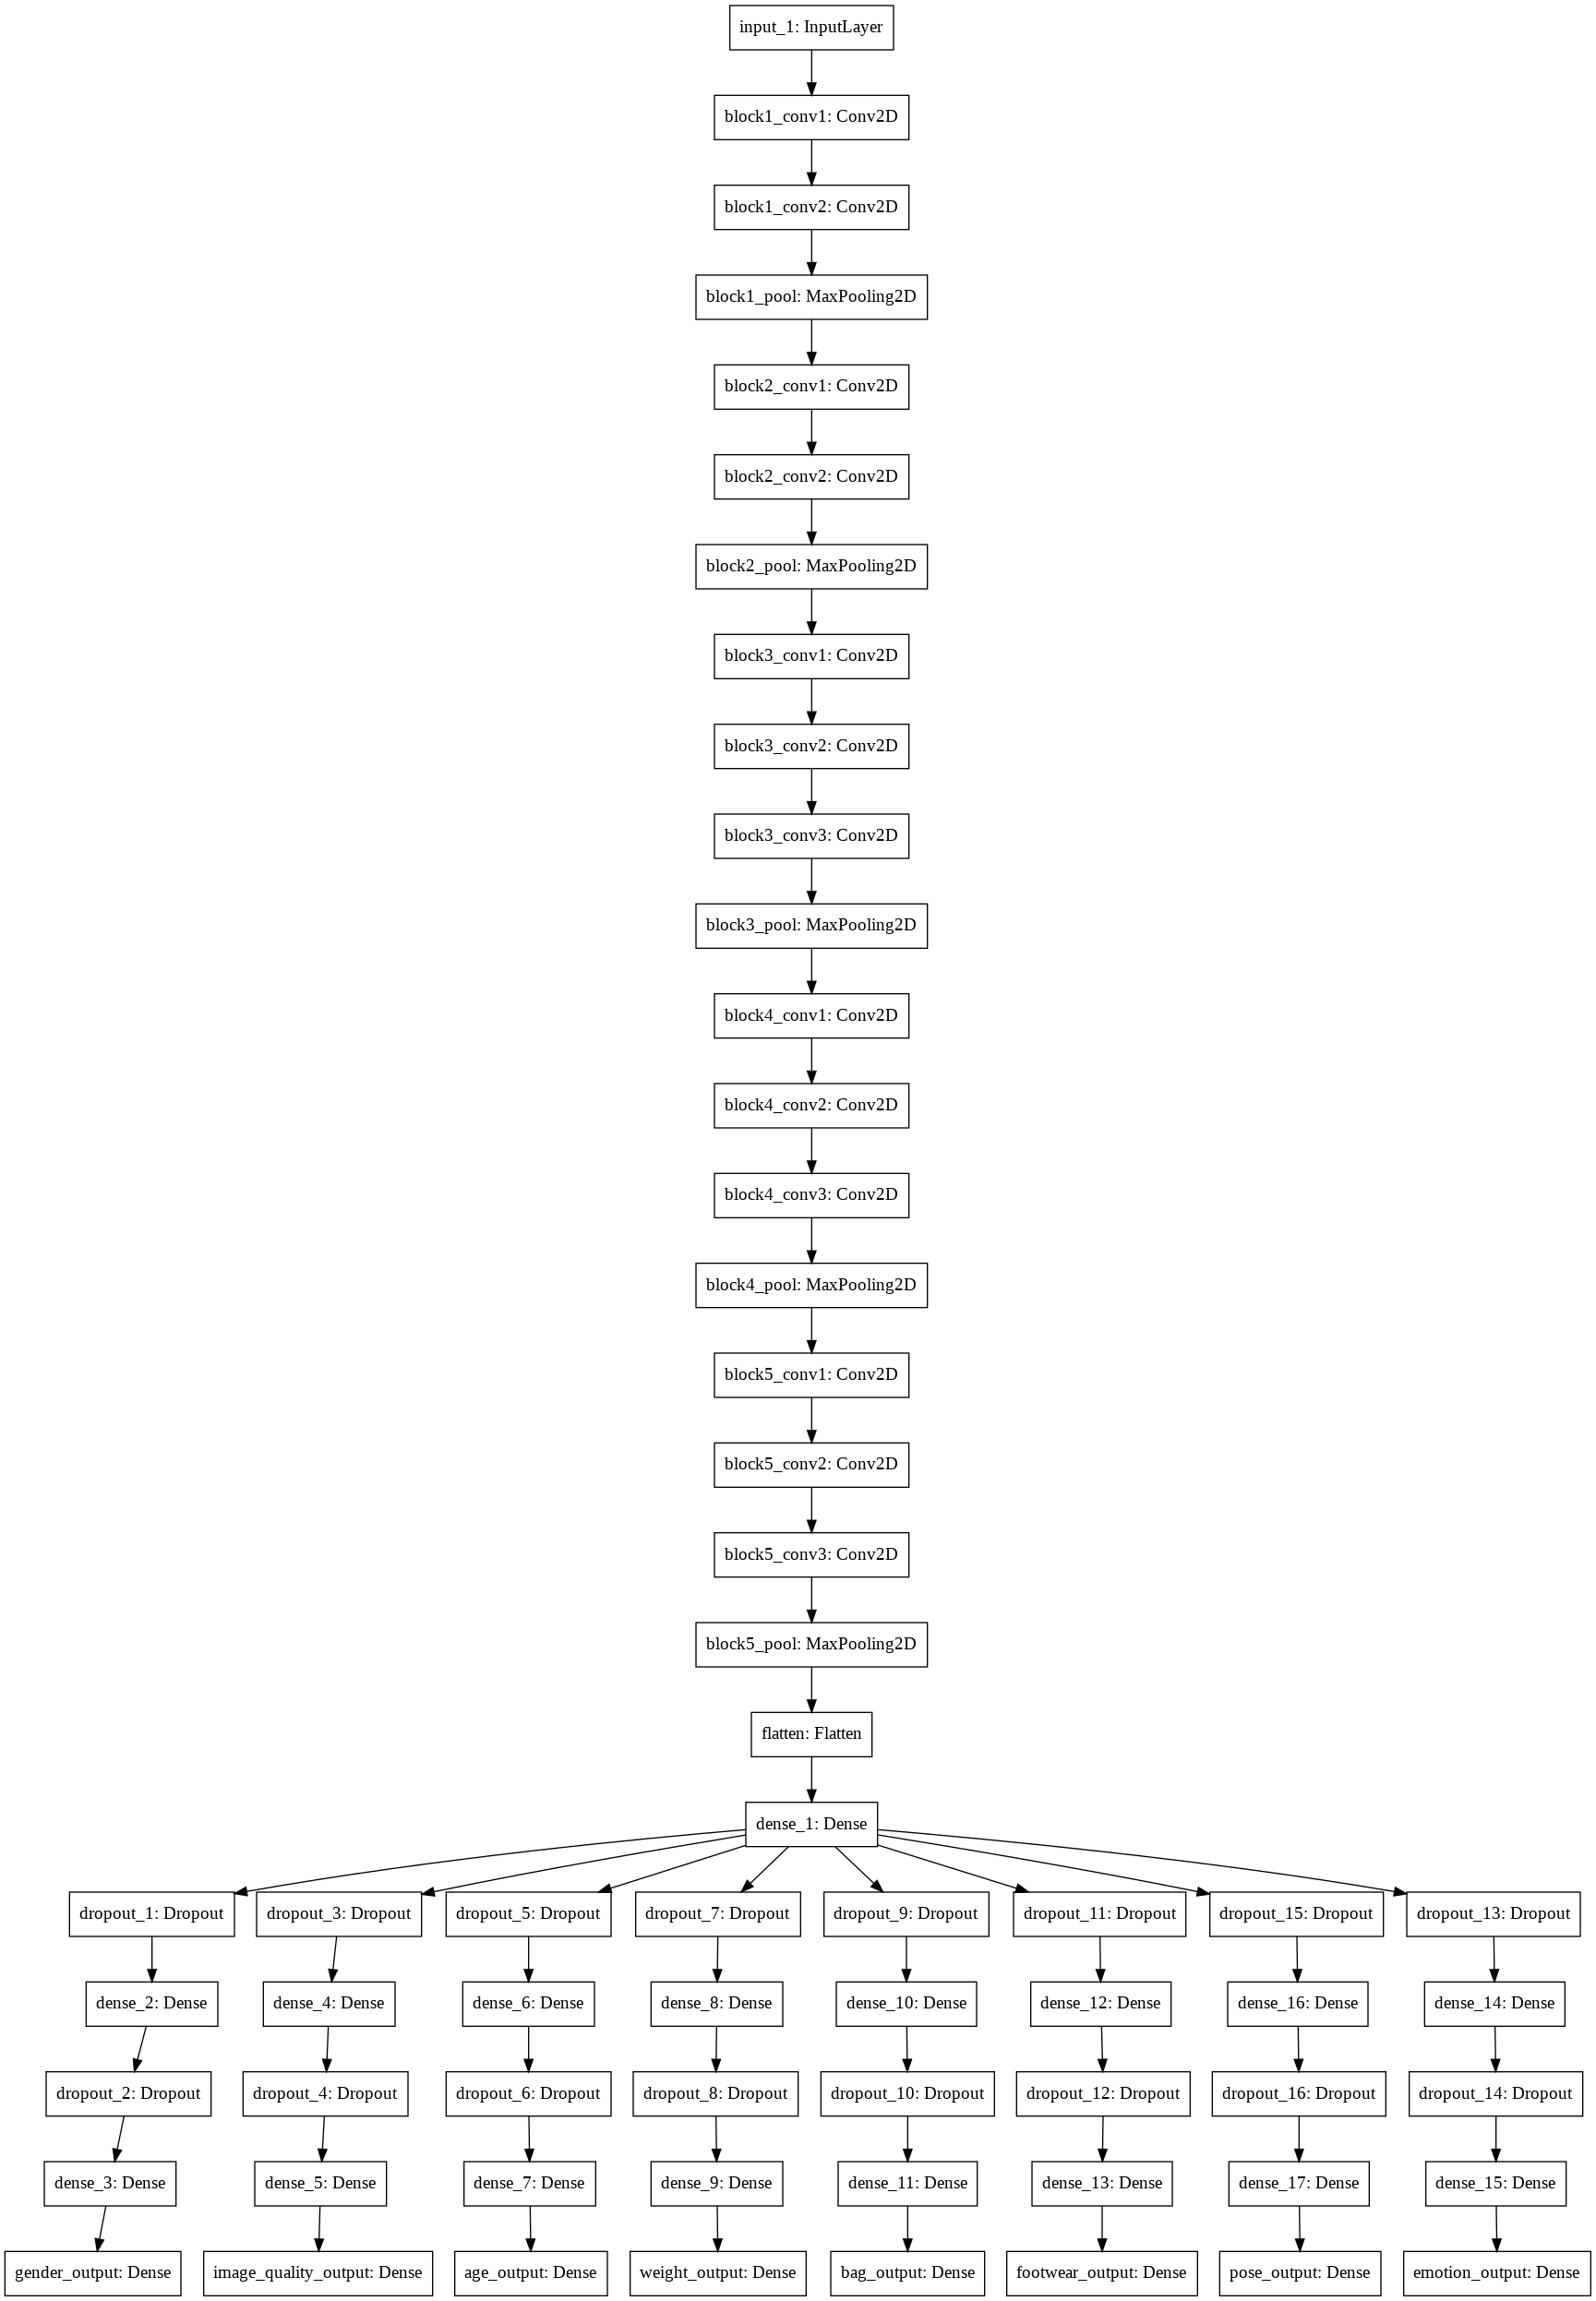

In [25]:
from keras.utils import plot_model
plot_model(model, to_file='/content/gdrive/My Drive/EIP/Assignment5Dataset/model.png')